# Silvia Control
Evaluation od espresso machine control theory based upon [Control Bootcamp](https://www.youtube.com/playlist?list=PLMrJAkhIeNNR20Mz-VpzgfQs5zrYi085m) by Steve Brunton.

## Boundary DIagram
<img src="boiler_boundary_diagram.png" width="400" />


## System Dynamics

### Differential equations
The change of internal energy $\frac{dU}{dt}$ of an incompresssible substance is as follows where $c$ is the specific heat.

$$ \frac{dU}{dt} = m . c $$

Heat transfer $Q$ is:

$$ Q = \int_{0}^{\Delta{}T} \dot{Q} dt $$

The heat rate required to increase the boiler temperture is:  

$$ \dot{Q}_{net} = c . m . \frac{dT_{boiler}}{dt} $$

The convection gain, $\dot{Q}_{conv}$  is:

$$ \dot{Q}_{conv} = h_{conv} . A . (T_{amb} - T_{boiler}) $$

The net heat input to the boiler, $\dot{Q}_{net}$ is:

$$ \dot{Q}_{net} = \dot{Q}_{heat} + \dot{Q}_{conv} $$ 

So differetial temperature equation is:
$$ \frac{dT_{boiler}}{dt} = \frac{u}{cm} + \frac{hA}{cm}(T_{amb} - T_{boiler}) $$

### Finite time equations

The heat required to increase the boiler temperture is:  

$$ Q_{net} = c . m . (T_{boiler}^{(1)} - T_{boiler}^{(0)}) . \Delta{}t $$

The temperture of the boiler, $T_{boiler}$ after heating is therefore:
$$ T_{boiler}^{(1)} = \frac{ (\dot{Q}_{heat} + \dot{Q}_{conv}) . \Delta{}t }{ c . m } + T_{boiler}^{(0)} $$

$$ \Delta{}T_{boiler} = \frac{ (\dot{Q}_{heat} + h_{conv} . A . (T_{amb} - T_{boiler})) . \Delta{}t }{ c . m } $$

### Notes
The heat input $\dot{Q}_{heat}$ to the system equals the electrical power $P_{heat}$ of the element:  
$$ \dot{Q}_{heat} = P_{heat} $$

### State
$$ \vec{x} = \begin{bmatrix} x_0 \end{bmatrix} = \begin{bmatrix} T \end{bmatrix} $$

### Control
Looking at the equations  on the form:
$$ \dot{x} = Ax + Bu $$

To account for the constant term, define new variable $z$:
$$ z = x + \alpha $$
where:
$$ \alpha = \frac{hA}{cm}T_{amb} $$

The A matrix defines the system:
$$ A = \begin{bmatrix} \frac{hA}{cm} \end{bmatrix} $$

The B matrix is the control:
$$ B = \begin{bmatrix} \frac{1}{cm} \end{bmatrix} $$

Total, equation:
$$ \dot{x} = -\frac{hA}{cm}T + \frac{1}{cm}u + \frac{hA}{cm}T_{amb} $$ 
$$ \dot{z} = \begin{bmatrix} -\frac{hA}{cm} \end{bmatrix} z + \begin{bmatrix} \frac{1}{cm} \end{bmatrix} u $$

## System Properties

|Property |Quantity |Reference |
|:-        |:-        |:-         |
|Boiler Mass |- $kg$ |
|Boiler Specific Heat Capacity |375 $\frac{J}{kg.K}$ |[Engineering Toolbox](https://www.engineeringtoolbox.com/specific-heat-capacity-d_391.html) |
|Water Mass |- $kg$ |
|Water Specific Heat Capacity |4182 $\frac{J}{kg.K}$ |[Engineering Toolbox](https://www.engineeringtoolbox.com/specific-heat-capacity-d_391.html) |
| Natural Convection Coefficient | 10 $\frac{W}{m^2.K}$ |

In [359]:
import sympy as sp
from sympy.utilities.lambdify import lambdify
import numpy as np
import matplotlib.pyplot as plt
import control.matlab as ctrlm
import control as ctrl
from control import place
import slycot
from scipy import integrate

# State
T, dT = sp.symbols("T \dot{T}")
# Properties
m, c, h, T_amb, a = sp.symbols("m, c, h, T_amb, a")
# Control
u = sp.symbols("u")

## Define System Matricies
Define function for the temperature rate

In [360]:
z = sp.Matrix([T - h * a * T_amb / (c * m) ])
u = sp.Matrix([u])
A = sp.Matrix([-h * a / (c * m)])
B = sp.Matrix([1 / (c * m)])
A

Matrix([[-a*h/(c*m)]])

In [361]:
T_rate = A*z + B*u
sp.Eq(dT, T_rate, evaluate=False)

Eq(\dot{T}, Matrix([[-a*h*(T - T_amb*a*h/(c*m))/(c*m) + u/(c*m)]]))

In [362]:
r = 0.035
l = 0.09
area = 2 * 3.14 * r**2 + 2 * 3.14 * r * l

properties = {
    'm': 3,
    'c': 375,
    'h': 10,
    'T_amb': 20,
    'a': area
}
area

0.027475000000000003

## State space representation

In [363]:
# Redefine matricies in numpy form
A_np = np.array(A.subs(properties))
B_np = np.array(B.subs(properties))
C_np = np.array([1])
D_np = np.zeros((1))
A_np, B_np

(array([[-0.000244222222222222]], dtype=object),
 array([[1/1125]], dtype=object))

In [364]:
ss_model = ctrl.ss(A_np, B_np, C_np, D_np)
ss_model

A = [[-0.00024422]]

B = [[0.00088889]]

C = [[1.]]

D = [[0.]]

In [365]:
def convert_x_z(data, output, properties):
    h = properties['h']
    a = properties['a']
    T_amb = properties['T_amb']
    m = properties['m']
    c = properties['c']
    if output == "x":
        return data + h * a * T_amb / (c * m)
    else:
        return data - h * a * T_amb / (c * m)

## Design LQR Controller

In [366]:
Q = np.eye(A.shape[0])
R = 0.001
K = ctrl.lqr(ss_model, Q, R)[0]
K

matrix([[31.34922014]])

In [367]:
def heatMass(t, x, properties, uf):
    dx = np.empty([1])
    h = properties['h']
    a = properties['a']
    T_amb = properties['T_amb']
    m = properties['m']
    c = properties['c']
    u = uf(x)
    dx[0] = (u + h * a * (- x)) / (c * m)
    t_log.append(t)
    u_log.append(u.item(0))
    return dx

In [368]:
t_lims = (0, 6000)
tspan = np.arange(t_lims[0], t_lims[1], 1)
z0 = np.array([convert_x_z(0, 'z', properties)])  # Start temperature
wr = np.array([100])  # Target temperature
# uf = lambda x: -K @ (x - wr)
uf = lambda x: x * 0 + 100

t_log = []
u_log = []
# x = integrate.odeint(heatMass, x0, tspan, args=(properties, uf))
sol = integrate.solve_ivp(heatMass, t_lims, z0, method="DOP853", args=(properties, uf), t_eval=tspan)
sol.message

'The solver successfully reached the end of the integration interval.'

Text(0, 0.5, 'State')

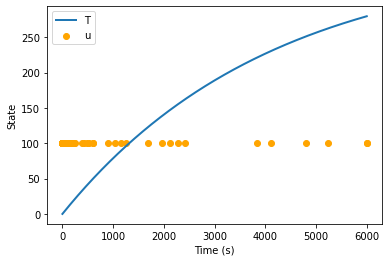

In [369]:
plt.plot(sol.t, convert_x_z(sol.y[0], "x", properties), linewidth=2, label='T')
plt.scatter(t_log, u_log, linewidth=1, label='u', c="orange")
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('State')

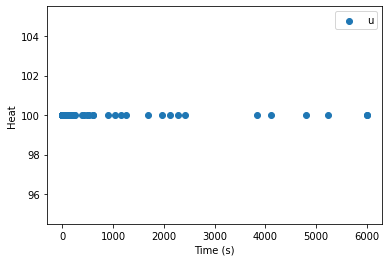

In [370]:
plt.scatter(t_log, u_log, linewidth=1, label='u')
plt.xlabel('Time (s)')
plt.ylabel('Heat')

plt.legend()
plt.show()

## Simulate with control library

Text(0.5, 0, 'Time (s)')

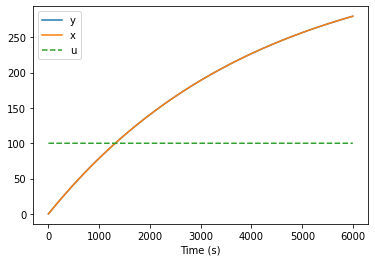

In [371]:
t_sample = 5
t_sim = np.arange(0, 6000, t_sample)
u_sim = t_sim * 0 + 100
t_step, y_step, x_step = ctrl.forced_response(ss_model, T=t_sim, U=u_sim, X0=z0)
plt.plot(t_step, convert_x_z(y_step, "x", properties), label='y')
plt.plot(t_step, convert_x_z(x_step, "x", properties), label='x')
plt.plot(t_step, u_sim, '--', label='u')
plt.legend()
plt.xlabel('Time (s)')

# Compare to measures response

Text(0.5, 0, 'Duty [%], Temperature [degC]')

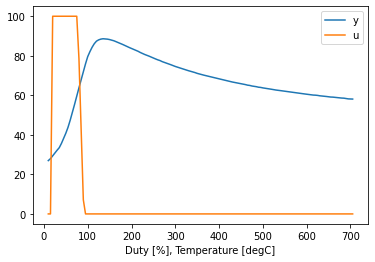

In [372]:
import pickle

with open('dataset_01.pickle', 'rb') as f:
    measured_data = pickle.load(f)
    
power = 1100  # W

plt.plot(measured_data["t"], measured_data["y"], label='y')
plt.plot(measured_data["t"], measured_data["u"], label='u')
plt.legend()
plt.xlabel('Time (s)')
plt.xlabel('Duty [%], Temperature [degC]')

## Simulate using measured input

Text(0.5, 0, 'Time (s)')

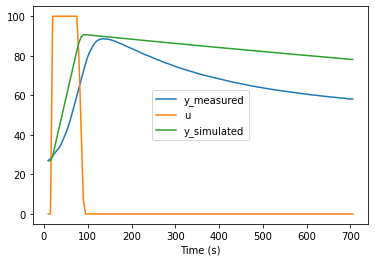

In [373]:
t_sim, y_sim, x_sim = ctrl.forced_response(
    ss_model, T=measured_data["t"], U=measured_data["u"]*power/100, X0=measured_data["y"][0]
)
plt.plot(measured_data["t"], measured_data["y"], label='y_measured')
plt.plot(measured_data["t"], measured_data["u"], label='u')
plt.plot(measured_data["t"], convert_x_z(y_sim, "x", properties), label='y_simulated')
plt.legend()
plt.xlabel('Time (s)')

Try changing the properties.

Text(0.5, 0, 'Time (s)')

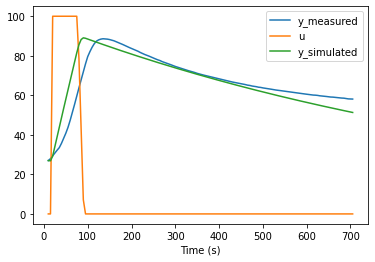

In [382]:
properties = {
    'm': 2,
    'c': 50,
    'h': 3,
    'T_amb': 20,
    'a': 0.03
}
A_np = np.array(A.subs(properties))
B_np = np.array(B.subs(properties))
ss_model = ctrl.ss(A_np, B_np, C_np, D_np)
t_sim, y_sim, x_sim = ctrl.forced_response(
    ss_model, T=measured_data["t"], U=measured_data["u"], X0=measured_data["y"][0]
)
plt.plot(measured_data["t"], measured_data["y"], label='y_measured')
plt.plot(measured_data["t"], measured_data["u"], label='u')
plt.plot(measured_data["t"], convert_x_z(y_sim, "x", properties), label='y_simulated')
plt.legend()
plt.xlabel('Time (s)')

The delay in the response is not being modelled as the boiler is assumed to be at constant temperature.